In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda:0'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [6]:
k = 1

In [7]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=1000,
    k=k,
    max_length=10,
    balanced=0.55,
)

Generating unbalanced strings: 100%|██████████| 450/450 [00:00<00:00, 73930.15it/s]
Saving dataset to data/dyck-1_1000-samples_10-len_p055.jsonl: 100%|██████████| 1000/1000 [00:00<00:00, 565803.86it/s]

Dataset saved to data/dyck-1_1000-samples_10-len_p055.jsonl


In [8]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()'

In [9]:
from dataset.dataset import DyckLanguageDataset

In [10]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 1000 samples from data/dyck-1_1000-samples_10-len_p055.jsonl


Tokenizing strings: 100%|██████████| 1000/1000 [00:00<00:00, 550795.01it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Manual Transformer + BERTViz


In [14]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    causal_mask,
    pad_token_mask,
)

In [15]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=384,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [16]:
model = TransformerClassifier(model_config)

In [17]:
model.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=384, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=384, out_features=256, bias=True)
        )
        (ln1): La

In [18]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=20,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0970 | Train Acc: 53.00%
Val Loss: 1.3673 | Val Acc: 53.33%
Epoch 2/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1090 | Train Acc: 52.75%
Val Loss: 1.3347 | Val Acc: 53.33%
Epoch 3/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.8813 | Train Acc: 55.00%
Val Loss: 1.3639 | Val Acc: 53.33%
Epoch 4/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9928 | Train Acc: 54.12%
Val Loss: 1.3141 | Val Acc: 45.83%
Epoch 5/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9479 | Train Acc: 51.00%
Val Loss: 1.2836 | Val Acc: 61.67%
Epoch 6/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.8133 | Train Acc: 55.00%
Val Loss: 1.3281 | Val Acc: 69.17%
Epoch 7/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9799 | Train Acc: 53.00%
Val Loss: 1.3734 | Val Acc: 54.17%
Epoch 8/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.7097 | Train Acc: 56.12%
Val Loss: 1.0634 | Val Acc: 100.00%
Epoch 9/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 5.0005 | Train Acc: 89.50%
Val Loss: 0.4332 | Val Acc: 100.00%
Epoch 10/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 1.4601 | Train Acc: 99.75%
Val Loss: 0.0533 | Val Acc: 100.00%
Epoch 11/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3185 | Train Acc: 100.00%
Val Loss: 0.0110 | Val Acc: 100.00%
Epoch 12/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1138 | Train Acc: 100.00%
Val Loss: 0.0047 | Val Acc: 100.00%
Epoch 13/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0506 | Train Acc: 100.00%
Val Loss: 0.0028 | Val Acc: 100.00%
Epoch 14/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0342 | Train Acc: 100.00%
Val Loss: 0.0022 | Val Acc: 100.00%
Epoch 15/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0266 | Train Acc: 100.00%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 16/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0216 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 17/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0191 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 18/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0145 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 19/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0105 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 20/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0085 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%


In [20]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.0021 | Test Acc: 100.00%


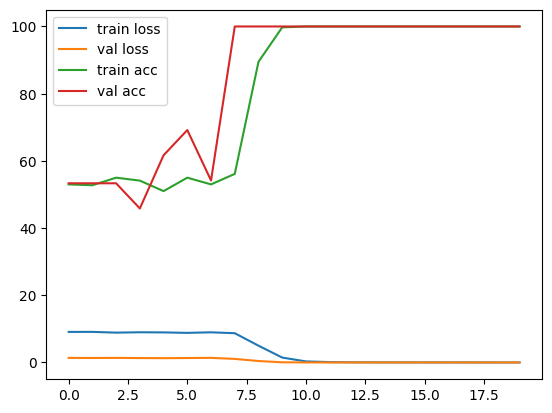

In [40]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

# Attention plots:


In [41]:
batch = next(iter(test_dataloader))
strings, labels, tokens = batch

mask = causal_mask(tokens)
attn_matrices = model.get_attn_matrices(tokens, mask)

In [23]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [24]:
from dataset.dataset import DyckLanguageTokenizer

In [87]:
batch = (
    "(()())(",
    True,
    DyckLanguageTokenizer(VOCAB).tokenize("(()())(").to(device),
)
batch

Tokenizing strings: 100%|██████████| 1/1 [00:00<00:00, 28532.68it/s]


('(()())(',
 True,
 tensor([[0., 3., 3., 4., 3., 4., 4., 3., 2.]], device='cuda:0'))

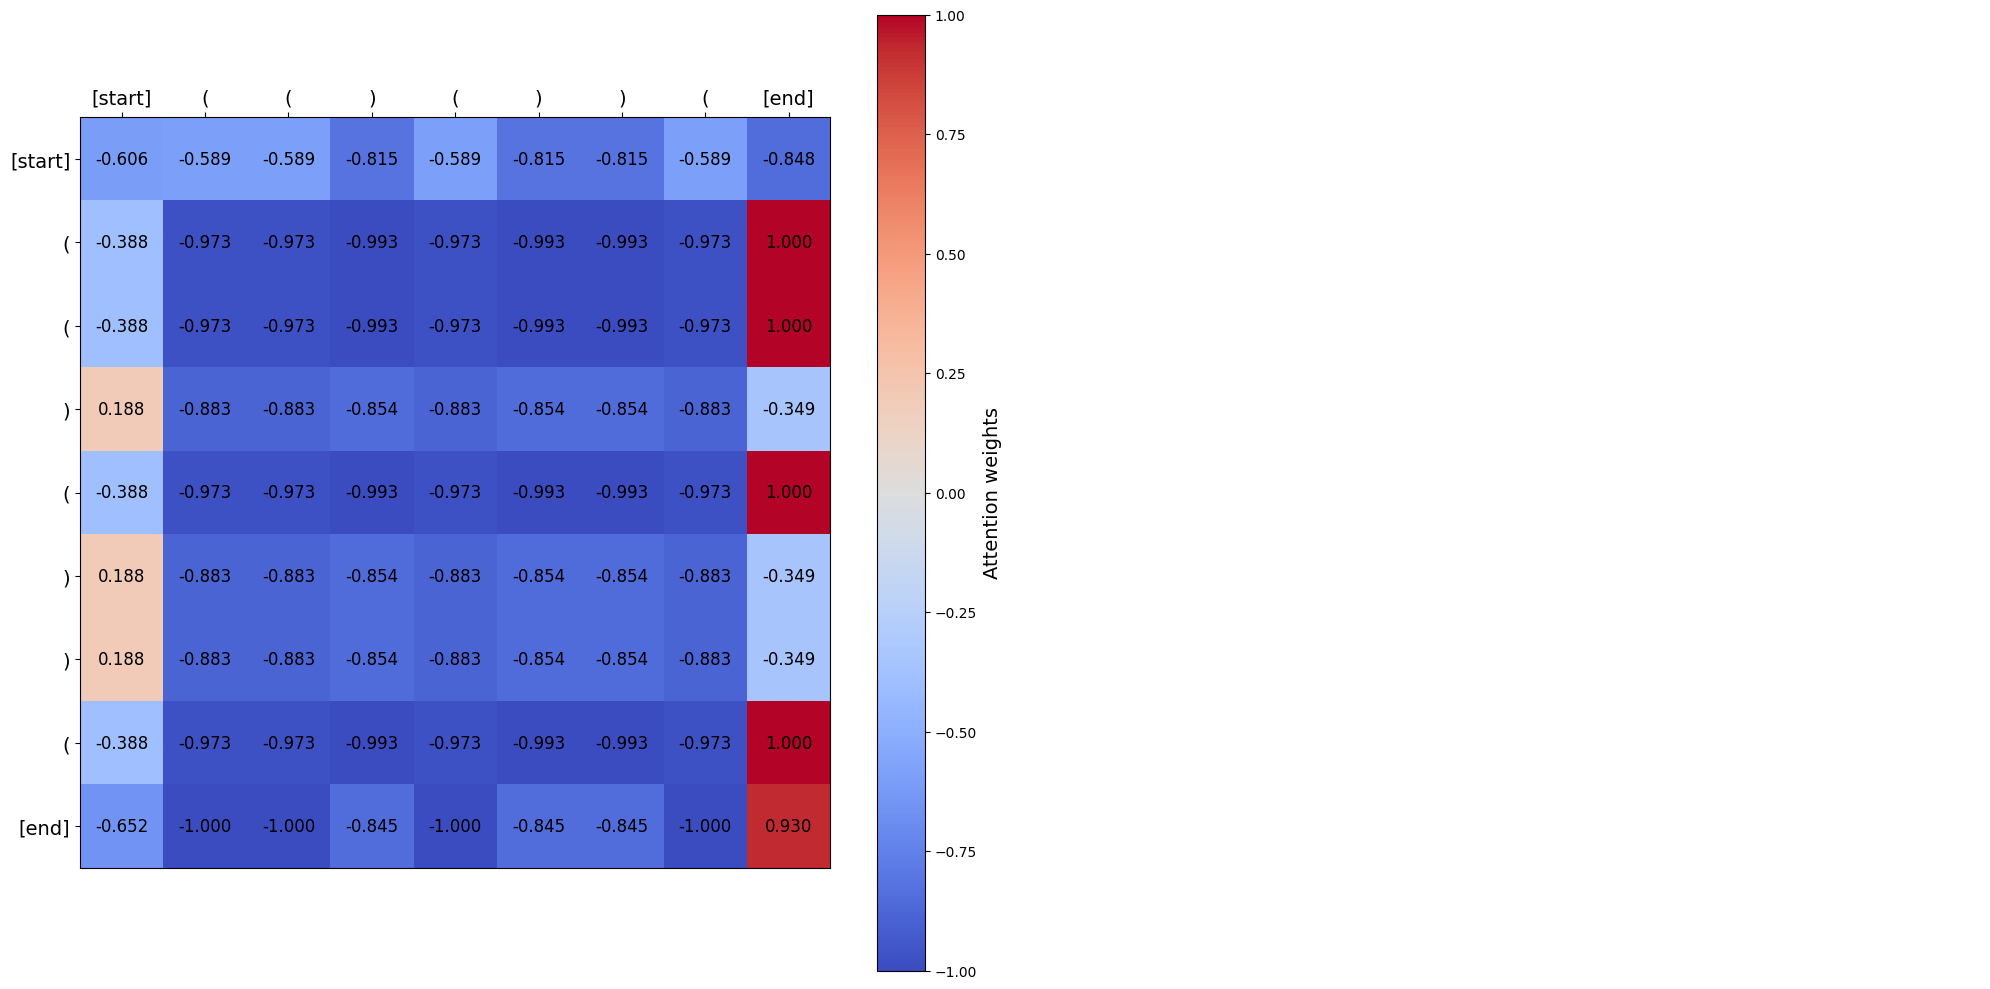

In [88]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)

In [27]:
minimax_norm = min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy())

In [28]:
minimax_norm[0][0]

1.0

# Experiment 2

We will experiment with the same grammar, using a causal mask instead of a bidirectional one.


In [29]:
model_two = TransformerClassifier(model_config).to(device)

# Experiment 3

Dyck-3


In [30]:
k = 3

In [60]:
path = generate_dataset(
    n=5_000,
    k=3,
    min_length=8,
    max_length=8,
    balanced=0.6,
)

Generating unbalanced strings: 100%|██████████| 2000/2000 [00:00<00:00, 47174.45it/s]
Saving dataset to data/dyck-3_5000-samples_8-len_p06.jsonl: 100%|██████████| 5000/5000 [00:00<00:00, 631767.43it/s]

Dataset saved to data/dyck-3_5000-samples_8-len_p06.jsonl


In [61]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()[]{}'

In [62]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 5000 samples from data/dyck-3_5000-samples_8-len_p06.jsonl


Tokenizing strings: 100%|██████████| 5000/5000 [00:00<00:00, 642529.49it/s]


In [63]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_dyck_2, [train_size, val_size, test_size])

In [64]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [72]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=512,
    n_heads=1,
    dim_ff=1024,
    n_layers=3,
    n_classes=2,
    max_seq_len=10,
)

In [73]:
model = TransformerClassifier(model_config).to(device)

In [74]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [75]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 8.2743 | Train Acc: 95.90%
Val Loss: 0.0153 | Val Acc: 100.00%
Epoch 2/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.1829 | Train Acc: 100.00%
Val Loss: 0.0042 | Val Acc: 100.00%
Epoch 3/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0876 | Train Acc: 100.00%
Val Loss: 0.0021 | Val Acc: 100.00%
Epoch 4/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0528 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 5/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0357 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 6/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0252 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 7/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0187 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 8/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0135 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 9/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0100 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 10/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0077 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 11/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0061 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 12/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0050 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 13/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0041 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0034 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0029 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%


In [76]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/50 [00:00<?, ?it/s]

Test Loss: 0.0003 | Test Acc: 100.00%


In [77]:
batch = next(iter(test_dataloader))
batch

[('[[][]()]',
  '[(){[]}]',
  '()()(())',
  '}((}[)))',
  '{}[][][]',
  '({}{{}})',
  '[]{}()[]',
  '}((}[)))'),
 tensor([1., 1., 1., 0., 1., 1., 1., 0.], device='cuda:0'),
 tensor([[0., 5., 5., 6., 5., 6., 3., 4., 6., 2.],
         [0., 5., 3., 4., 7., 5., 6., 8., 6., 2.],
         [0., 3., 4., 3., 4., 3., 3., 4., 4., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.],
         [0., 7., 8., 5., 6., 5., 6., 5., 6., 2.],
         [0., 3., 7., 8., 7., 7., 8., 8., 4., 2.],
         [0., 5., 6., 7., 8., 3., 4., 5., 6., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.]], device='cuda:0')]

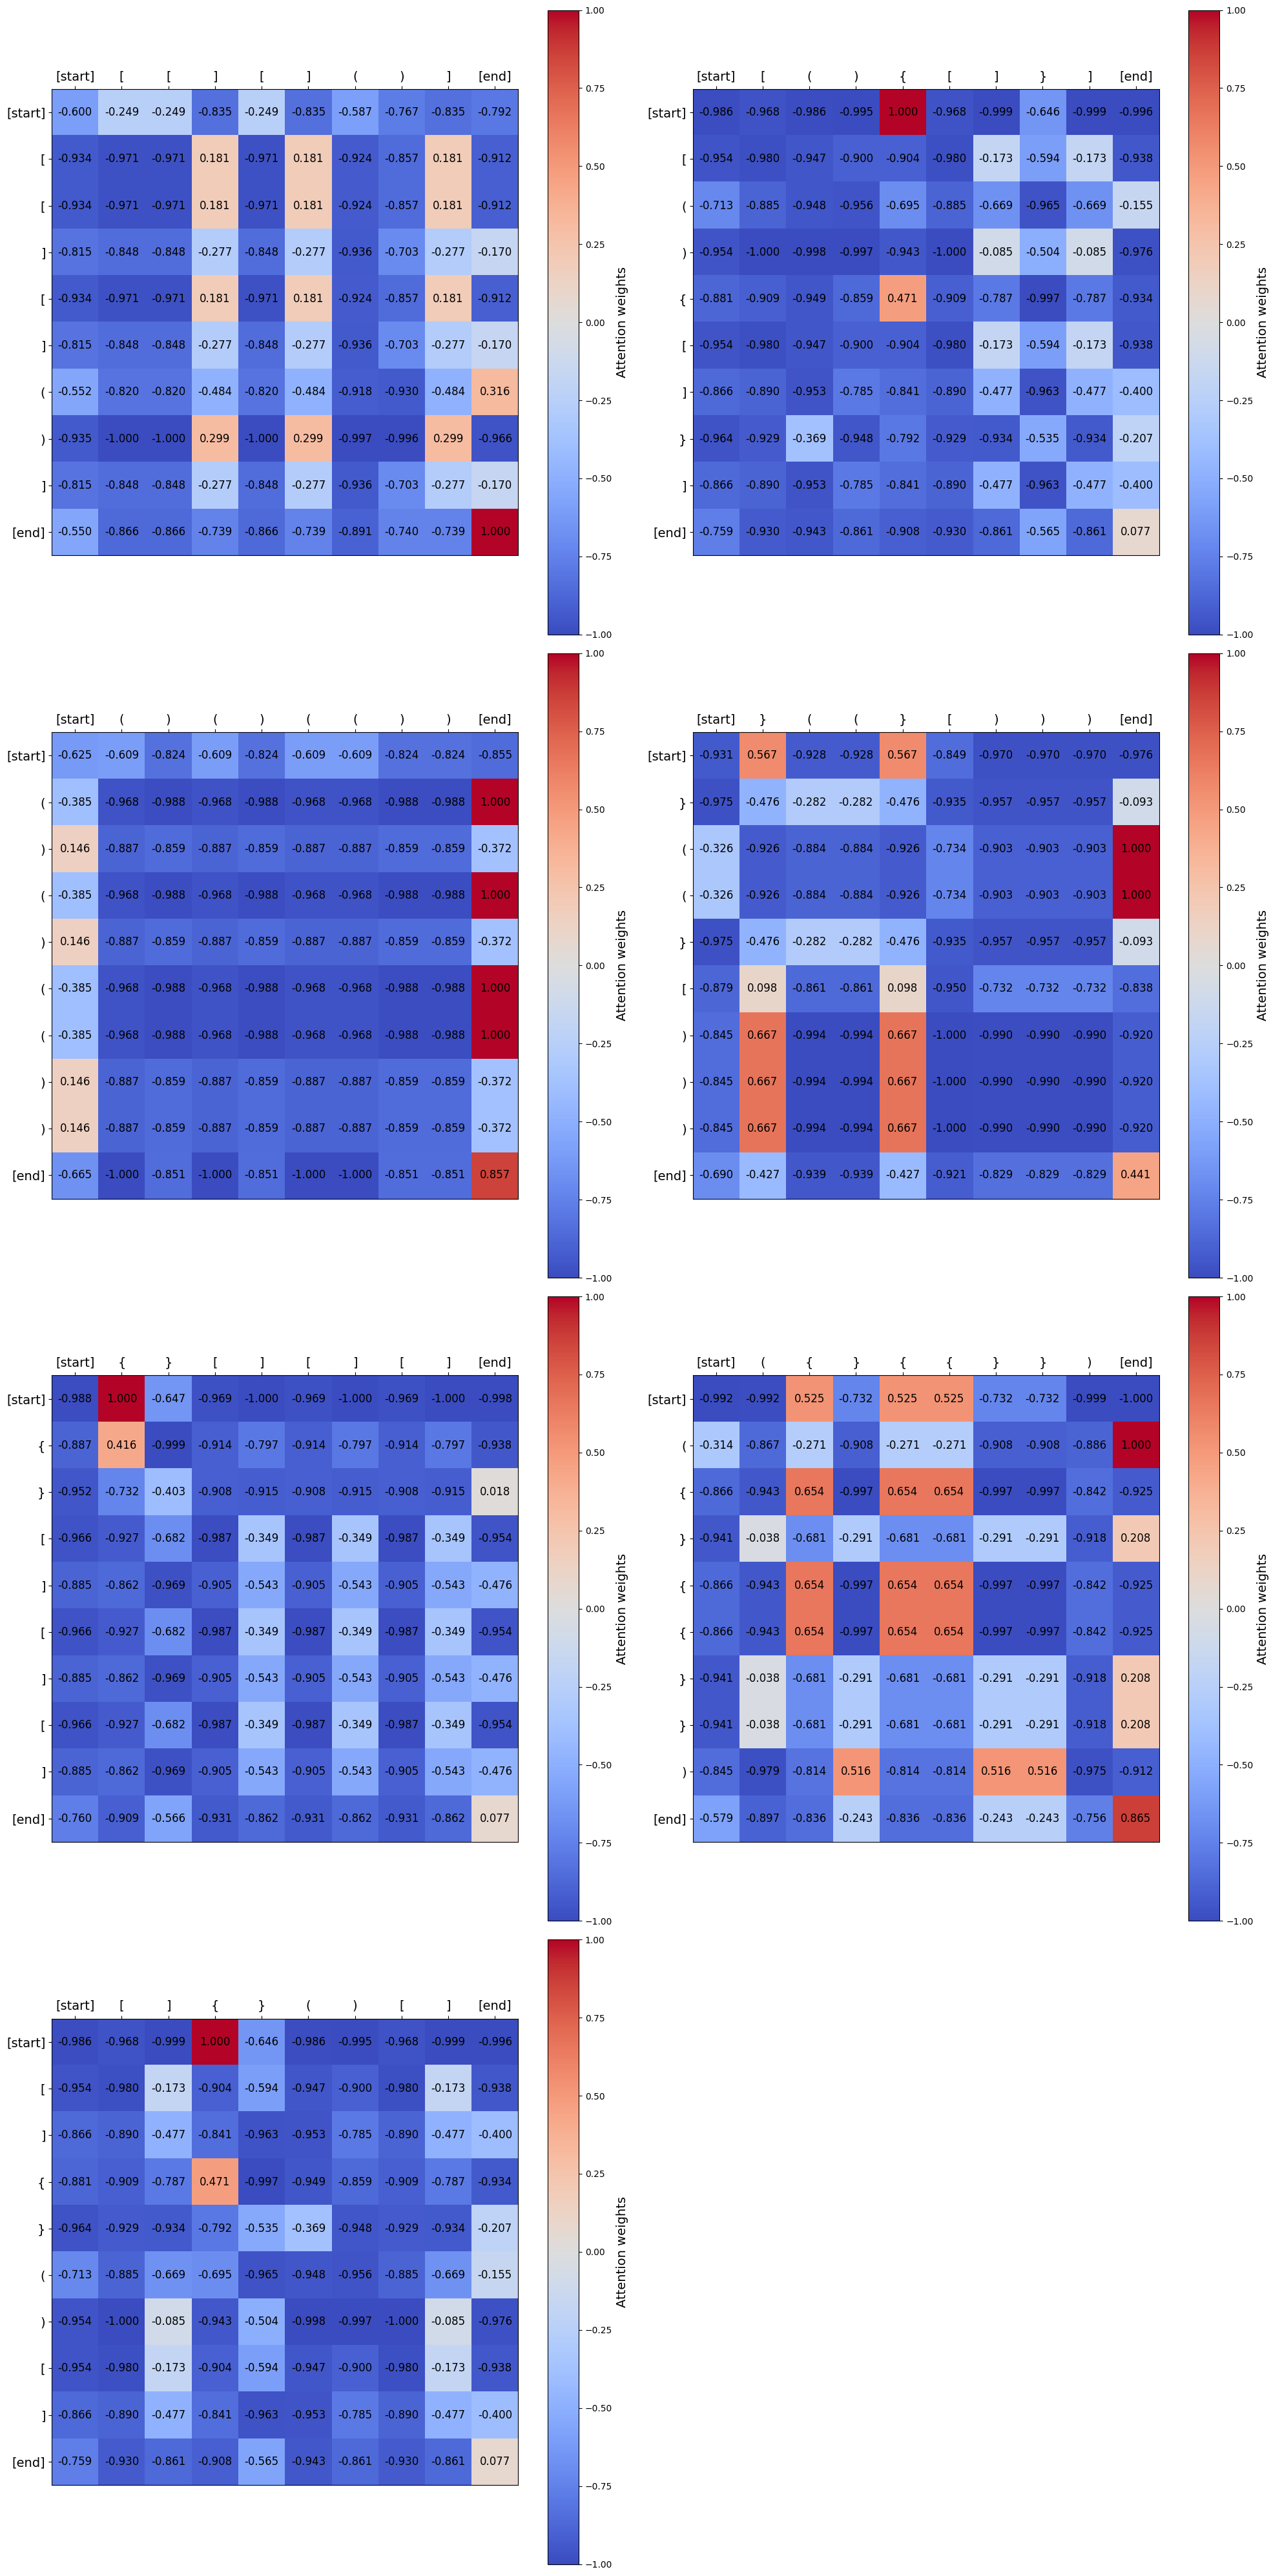

In [78]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)